# Train travel comments dataset topic modeling

## Summary

The objective of this task is to extract the topics that people are talking about and provide insights that help the client calibrate their internal strategy on how to improve customer experience.

In this notebook, we explore two unsupervised topic modeling approaches:

- The first approach uses POS tagging and Latent Dirichlet Allocation (LDA). We ran a grid search over 225 configurations, but failed to identify any coherent topics in the customer reviews. 

- The second approach uses SentenceBERT to create semantic embeddings from entire reviews & titles, and then clustering the embeddings using K-Means clustering. Using t-SNE, we then visualize the results and identify that there are **three topics** customers are most concerned with. 

Based on the URLs we also identified that the clusters are biased by train company, because the reviews contain mentions of the specific companies (e.g., Virgin, GWR, EUROSTAR). Therefore, we split the dataset into five subsets: virgintrains, southernrailway, gwr, eurostar, all remaining train companies — and rerun the word embedding clustering on the subsets. Finally, we plot word clouds of the top-30 words by frequency without topic overlap.

---

## Findings by train company

#### Virgin Trains

The word clouds for Virgin Trains reviews reveal three main areas of discussion among customers. 

- Cluster 1 suggests **issues with customer service** and the refund process, with frequent mentions of "refund", "email", "complaint", and "delay". 

- Cluster 2 focuses on **operational aspects** of the train service, with mixed sentiments emerging from discussions around the reliability and efficiency of the trains, ticket booking, and the routes covered.

- Cluster 3 points to the **onboard experience**, with notable concerns about the cleanliness of the carriages and the quality of provisions like "coffee" and "tea" suggesting passenger dissatisfaction with the physical environment and amenities on the trains.

#### Southern Railway

The word clouds for Southern Railway reviews allow us to identify two areas of customer dissatisfaction:

- Cluster 2, similar to Virgin Trains, emphasizes the negative sentiment towards the **website and customer service**, with words like "rude", "disaster", and "failed". 

- Cluster 3 is dominated by the terms "late," "delayed," and "cancelled," pointing to concerns regarding **punctuality and reliability** of train services.

#### Great Western Railway (GWR)

For GWR, we identified three important topics, similarly to Virgin:

- Cluster 1 focuses on the **unfair pricing** of the services w.r.t. their quality, as well as train occupancy and customer priorities (1st class). 

- Clusters 2 and 3 highlight issues with **customer support, communications**, cleanliness and comfort of the carriages, similarly to Cluster 3 of Virgin.

#### Eurostar

The issues raised about Eurostar are both serious and concerning:

- Cluster 1 focuses on **long-term customer rewards and the impact of service disruptions**, with references to "points", "years", "strikes", and "complaint". 

- Cluster 2 is centered around **ticketing experiences**, with words like "ticket," "book," "pay," and "cancelled," indicating possible frustration with the booking process and ticket changes. 

- Cluster 3 presents a rather concerning picture with words like "claim," "racist," and "threatening," which may point to serious allegations regarding **customer interactions and social issues**, although without context, the exact nature of these concerns isn't entirely clear.

#### Companies with fewer than 100 reviews

The remaining 10 companies had fewer than 100 reviews, so we grouped them together into the final subset:

- Cluster 1 is predominantly about **on-board catering services** with keywords like "class", "coffee", "food", and "drinks".

- Cluster 2 features terms such as "train," "service," "ticket," and "time," which likely refer to the efficiency and effectiveness of the **train services and ticketing experiences**. 

- Similarly to other trainlines, Cluster 3 centers on **customer feedback and customer support**, with "review," "horrible," "design," and "complaint" being prominent.

---

## Insights and Suggestions:

- **Enhance Refund and Complaint Handling**: Create a streamlined, transparent refund process and a more effective complaint resolution pathway, possibly through an improved online interface where customers can easily submit and track their concerns.

- **Operational Efficiency and Punctuality**: Address operational issues that lead to train delays and cancellations, aiming to improve punctuality and reliability, which are frequent points of customer dissatisfaction.

- **Onboard Cleanliness and Amenities**: Implement strict cleanliness standards and regular inspections of carriages, along with an upgrade in the quality of onboard amenities such as food and beverages.

- **Customer Service Training**: Intensify customer service training, focusing on courtesy and problem-solving skills, to address negative sentiments towards staff interactions and improve overall customer experience.

- **Ticketing System Improvement**: Revamp the ticketing system to make it more reliable and user-friendly, reducing booking errors and simplifying the process for changes and cancellations to reduce customer frustration.


## Structure

1. [Initial exploration with pandas](#pandas)

2. [Latent Dirichlet Allocation (LDA)](#lda)

3. [Word Embeddings with Sentence-BERT](#sbert)

4. [Word Clouds by Train Company](#trains)

In [1]:
import os
import json
import re
import string
from typing import Any, Dict, List, Tuple

import pandas as pd
import numpy as np
from collections import Counter
from tqdm.auto import tqdm

import gensim
from gensim import corpora
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

DATA_PATH = '/Users/kremerr/Documents/GitHub/OkraAI-interview/data/train_reviews.json'

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kremerr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kremerr/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kremerr/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kremerr/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Reviewing the dataset with Pandas
<a id='pandas'></a>


In [2]:
df = pd.read_json(DATA_PATH)
df.head()

,date,title,text,url,stars
0,2015-10-10 14:32:51+00:00,Bad customer service. Staff are very impolite ...,Used national rail twice and on both occasions...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-1 star-rating--medium
1,2015-09-22 17:04:56+00:00,Pretty awful service,I phoned National rail to find out why several...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-1 star-rating--medium
2,2015-03-13 23:37:05+00:00,Awful staff,I travel from Brokenhast to southampton centra...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-1 star-rating--medium
3,2015-01-13 12:26:52+00:00,Very good,Saved about £50 on a single trip using Nationa...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-4 star-rating--medium
4,2011-05-28 15:00:36+00:00,Check it out.,I always use the national rail enquiry site wh...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-4 star-rating--medium


In [3]:
print(df['text'][0])

Used national rail twice and on both occasions I found the staff unpleasant, unfriendly and incompetent. Wasn't helpful in regards to platform information and general customer service skills.


In [4]:
print(min(df['date']))
print(max(df['date']))

2011-05-28 15:00:36+00:00
2018-07-17 13:59:52+00:00


In [5]:
df['stars'].value_counts()

stars
star-rating star-rating-1 star-rating--medium    1601
star-rating star-rating-5 star-rating--medium     153
star-rating star-rating-2 star-rating--medium     136
star-rating star-rating-4 star-rating--medium      69
star-rating star-rating-3 star-rating--medium      62
Name: count, dtype: int64

In [6]:
urls = df['url']
pattern = re.compile(r'https://uk\.trustpilot\.com/review/([^?]+)')
# Extracting unique parts
unique_parts = [pattern.search(url).group(1) for url in urls if pattern.search(url)]
# Removing potential duplicates by converting the list to a set, then back to a list
unique_parts = list(set(unique_parts))

unique_parts

['www.southwesternrailway.com',
 'www.buytickets.crosscountrytrains.co.uk',
 'www.southeasternrailway.co.uk',
 'www.eurostar.com',
 'chilternrailways.co.uk',
 'www.virgintrainseastcoast.com',
 'www.grandcentralrail.com',
 'www.tpexpress.co.uk',
 'www.nationalrail.co.uk',
 'www.virgintrains.co.uk',
 'www.southernrailway.com',
 'sleeper.scot',
 'www.hulltrains.co.uk',
 'www.arrivatrainswales.co.uk',
 'www.eastmidlandstrains.co.uk',
 'www.londonnorthwesternrailway.co.uk',
 'www.gwr.com']

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2021 entries, 0 to 2020
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   date    2021 non-null   datetime64[ns, UTC]
 1   title   2021 non-null   object             
 2   text    2021 non-null   object             
 3   url     2021 non-null   object             
 4   stars   2021 non-null   object             
dtypes: datetime64[ns, UTC](1), object(4)
memory usage: 79.1+ KB


## Latent Dirichlet Allocation (LDA)

For topic extraction, we will use a topic modelling technique called Latent Dirichlet Allocation (LDA). 
For LDA to work, we first need to perform some preprocessing steps, namely:
- Text Cleaning
  - lowercasing
  - removing punctuation
  - removing stopwords (optional)
  - lemmatization (optional)
- Tokenization
- Vectorization

<a id='lda'></a>


In [8]:
def load_data(
        file_path: str
    ) -> List[Dict[str, Any]]:
    """
    Load the JSON data from the given file path.
    
    Args:
        file_path (str): The path to the JSON file.
        
    Returns:
        list: A list of dictionaries, where each dictionary represents a customer review.
    """
    with open(file_path, 'r') as f:
            data = json.load(f)

    # Regular expression to extract the unique part of each URL
    url_pattern = re.compile(r'https://uk\.trustpilot\.com/review/([^?]+)')

    # Combine title and text for each review and use it to check for duplicates
    seen_reviews = set()
    unique_data = []
    for review in data:
        combined_review = review['title'] + " " + review['text']
        if combined_review not in seen_reviews and review['stars'] != "star-rating star-rating-5 star-rating--medium":
            seen_reviews.add(combined_review)
            if 'url' in review:
                match = url_pattern.search(review['url'])
                if match:
                    review['url'] = match.group(1)
            unique_data.append(review)
            

    print(f"Removed {len(data) - len(unique_data)} duplicates, {len(unique_data)} reviews remain.")
    return unique_data

def preprocess_text(
        text: str, 
        lemmatize: bool = True,
        remove_stopwords: bool = False
    ) -> str:
    """
    Preprocess the given text by removing URLs, digits, and punctuation, and converting to lowercase.
    
    Args:
        text (str): The input text to preprocess.
        
    Returns:
        str: The preprocessed text.
    """
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize and POS tag
    tokens = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(tokens)

    # Keep only nouns, adjectives, and verbs
    allowed_tags = ['NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
    filtered_tokens = [word for word, tag in tagged if tag in allowed_tags]

    # Remove stopwords
    if remove_stopwords:
        filtered_tokens = [word for word in filtered_tokens if word.lower() not in stop_words]
    
    # Lemmatize
    if lemmatize:    
        filtered_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    # Convert to lowercase
    filtered_tokens = [token.lower() for token in filtered_tokens]

    return ' '.join(filtered_tokens)


def create_corpus(
        data: List[Dict[str, Any]]
    ) -> Tuple[corpora.Dictionary, List[List[Tuple[int,int]]]]:
    """
    Create a corpus from the preprocessed data.
    
    Args:
        data (list): A list of dictionaries representing the customer reviews.
        
    Returns:
        gensim.corpora.Dictionary: A dictionary mapping words to word IDs.
        list: A list of bag-of-words vectors representing the corpus.
    """
    # texts = [word_tokenize(preprocess_text(review['text'])) for review in data]
    texts = []
    for review in data:
        # Combine title and text
        full_text = review['title'] + " " + review['text']
        processed_text = preprocess_text(full_text)
        
        texts.append(word_tokenize(processed_text))

    dictionary = corpora.Dictionary(texts)
    dictionary.filter_extremes(no_below=2, no_above=0.5)
    corpus = [dictionary.doc2bow(text) for text in texts]

    return dictionary, corpus


def train_lda_model(
        corpus: List[List[Tuple[int,int]]], 
        dictionary: corpora.Dictionary, 
        num_topics: int = 5
    ) -> gensim.models.LdaMulticore:
    """
    Train an LDA model on the given corpus.
    
    Args:
        corpus (list): A list of bag-of-words vectors representing the corpus.
        dictionary (gensim.corpora.Dictionary): A dictionary mapping words to word IDs.
        num_topics (int): The number of topics to extract.
        
    Returns:
        gensim.models.LdaMulticore: The trained LDA model.
    """
    lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics)
    return lda_model


def visualize_topics(
        lda_model: gensim.models.LdaMulticore, 
        corpus: List[List[Tuple[int,int]]], 
        dictionary: corpora.Dictionary
    ) -> None:
    """
    Visualize the topics extracted by the LDA model using PyLDAvis.
    
    Args:
        lda_model (gensim.models.LdaMulticore): The trained LDA model.
        corpus (list): A list of bag-of-words vectors representing the corpus.
        dictionary (gensim.corpora.Dictionary): A dictionary mapping words to word IDs.
    """
    pyLDAvis.enable_notebook()
    vis_data = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
    pyLDAvis.show(vis_data, local=False)


def grid_search_lda_hyperparameters(
    corpus: List[List[Tuple[int, int]]],
    dictionary: corpora.Dictionary,
    data: List[Dict[str, Any]],
    alphas: List[float],
    betas: List[float],
    num_topics_range: Tuple[int, int],
    evaluate_every: int = 1
) -> Dict[Tuple[float, float, int], float]:
    """
    Perform a grid search over the hyperparameters of the LDA model and evaluate the coherence of the topic model
    at each configuration.

    Args:
        corpus (List[List[Tuple[int, int]]]): A list of bag-of-words vectors representing the corpus.
        dictionary (corpora.Dictionary): A dictionary mapping words to word IDs.
        alphas (List[float]): A list of alpha values to search over.
        betas (List[float]): A list of beta values to search over.
        num_topics_range (Tuple[int, int]): A tuple representing the range of number of topics to search over.
        evaluate_every (int): The number of iterations after which the coherence should be evaluated.

    Returns:
        Dict[Tuple[float, float, int], float]: A dictionary mapping the hyperparameter configuration (alpha, beta, num_topics)
            to the corresponding coherence score.
    """
    results = []
    num_topics_min, num_topics_max = num_topics_range

    tokenized_texts = [word_tokenize(preprocess_text(review['text'])) for review in data]

    
    total_iterations = len(alphas) * len(betas) * (num_topics_max - num_topics_min + 1)
    pbar = tqdm(total=total_iterations, desc="Grid Search Progress")
    
    for alpha in alphas:
        for beta in betas:
            for num_topics in range(num_topics_min, num_topics_max + 1):
                lda_model = gensim.models.LdaMulticore(
                    corpus=corpus,
                    id2word=dictionary,
                    num_topics=num_topics,
                    alpha=alpha,
                    eta=beta,
                    eval_every=evaluate_every
                )

                coherence_model = CoherenceModel(
                    model=lda_model,
                    texts=tokenized_texts,
                    dictionary=dictionary,
                    coherence='c_v'
                )

                coherence = coherence_model.get_coherence()
                results.append({"alpha": alpha, "beta": beta, "num_topics": num_topics, "coherence": coherence})
                
                pbar.update(1)
    pbar.close()

    results_df = pd.DataFrame(results)
    return results_df

In [9]:
data = load_data(DATA_PATH)
dictionary, corpus = create_corpus(data)
lda_model = train_lda_model(corpus, dictionary, num_topics=5)

tokenized_texts = [word_tokenize(preprocess_text(review['text'])) for review in data]
coherence_model = CoherenceModel(
                    model=lda_model,
                    texts=tokenized_texts,
                    dictionary=dictionary,
                    coherence='c_v'
                )
coherence = coherence_model.get_coherence()
print("Baseline coherence score: ", coherence)

Removed 703 duplicates, 1318 reviews remain.
Baseline coherence score:  0.42634675351398943


In [10]:
visualize_topics(lda_model, corpus, dictionary)

Serving to http://127.0.0.1:8888/    [Ctrl-C to exit]


127.0.0.1 - - [14/Mar/2024 17:34:48] "GET / HTTP/1.1" 200 -



stopping Server...


In [11]:
alphas = [0.1, 0.5, 1.0, 'symmetric', 'asymmetric']
betas = [0.1, 0.5, 1.0, 'symmetric', 'auto']
num_topics_range = (3, 10)

data = load_data(DATA_PATH)
dictionary, corpus = create_corpus(data)

results_df = grid_search_lda_hyperparameters(
    corpus, 
    dictionary, 
    data, 
    alphas, 
    betas, 
    num_topics_range)

# Save results to a CSV file
results_df.to_csv('lda_grid_search_results_tfidf.csv', index=False)

Removed 703 duplicates, 1318 reviews remain.


Grid Search Progress:   0%|          | 0/200 [00:00<?, ?it/s]

In [12]:
sorted_results = results_df.sort_values(axis=0, by=['coherence'], ascending=False, inplace=False)
sorted_results.head()

,alpha,beta,num_topics,coherence
20,0.1,1.0,7,0.450223
179,asymmetric,1.0,6,0.447639
116,1.0,auto,7,0.447313
152,symmetric,auto,3,0.446430
72,0.5,auto,3,0.445334


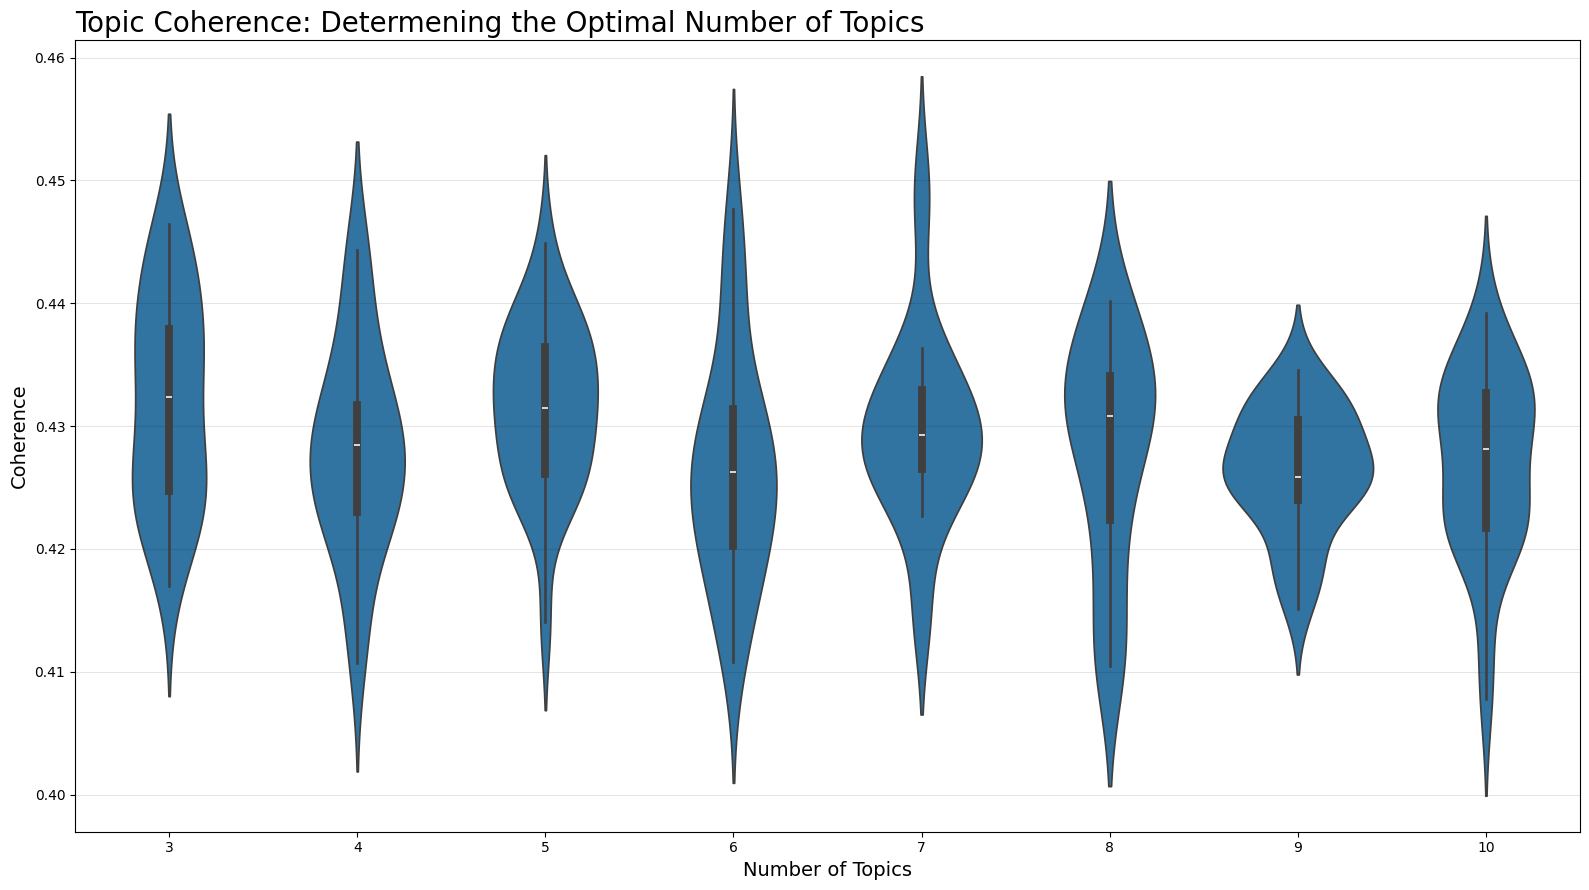

In [14]:
fig, ax = plt.subplots(figsize=(16,9))
sns.violinplot(ax=ax, data=results_df, x='num_topics', y='coherence')
ax.set_xlabel('Number of Topics', fontsize=14)
ax.set_ylabel('Coherence', fontsize=14)
ax.set_title('Topic Coherence: Determening the Optimal Number of Topics', loc='left', fontsize=20)
ax.yaxis.grid(color='black', which='both', alpha=0.1)
plt.tight_layout()
plt.show()

fig.savefig("../images/Topic Coherence.png", dpi=60)


In [15]:
lda_model = gensim.models.LdaMulticore(
                    corpus=corpus,
                    id2word=dictionary,
                    num_topics=7,
                    alpha=0.1,
                    eta=1.0
                )

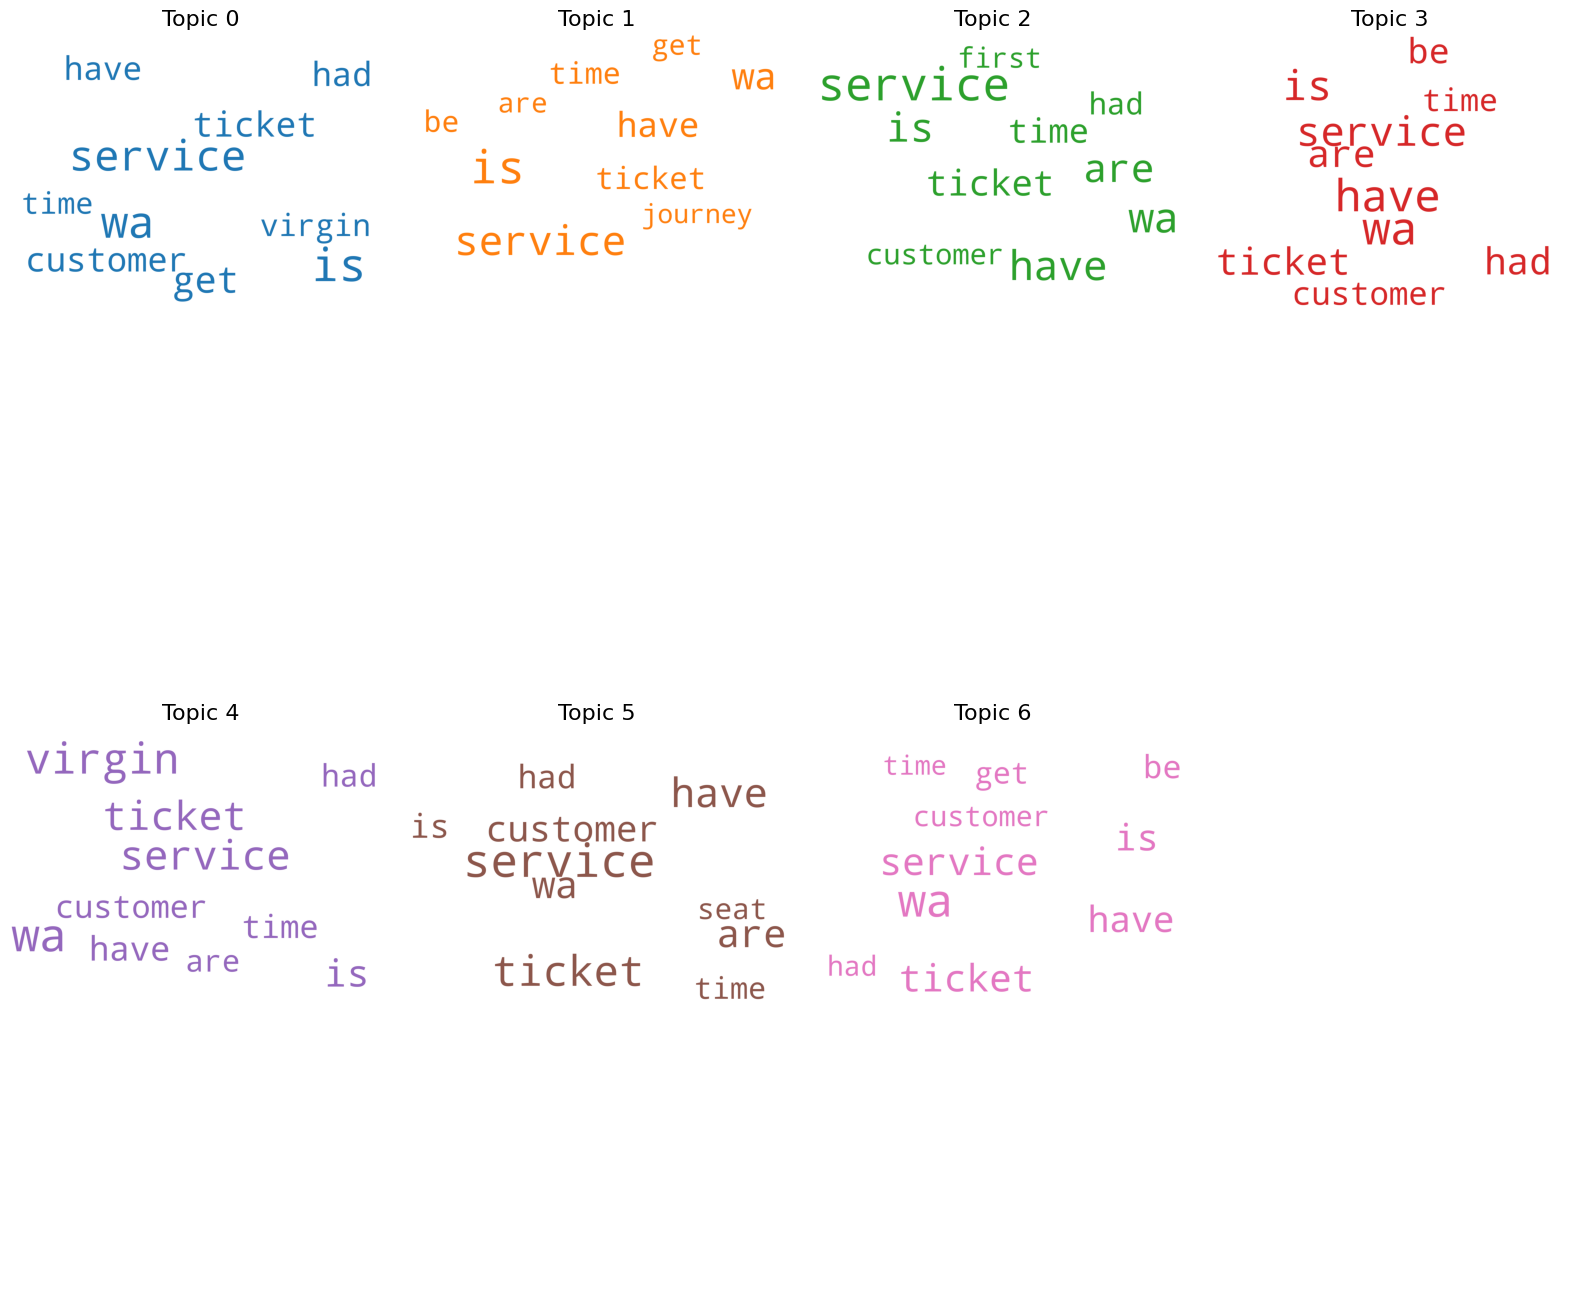

In [18]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # Color list for the word clouds

cloud = WordCloud(
    background_color='white',
    width=2500,
    height=1800,
    max_words=20,
    colormap='tab10',
    color_func=lambda *args, **kwargs: cols[i % len(cols)],  # Use modulo to cycle through colors
    prefer_horizontal=1.0)

topics = lda_model.show_topics(num_topics=14, formatted=False)  # Ensure 14 topics are retrieved

# Calculate the number of subplot rows and columns needed to accommodate 14 topics
n_rows = 2
n_cols = 4  # Using 4 columns, the last two subplots will be empty

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 16), sharex=True, sharey=True)

# Hide the last two axes as they won't display any topics
axes[-1, -2].axis('off')
axes[-1, -1].axis('off')

for i, ax in enumerate(axes.flatten()):  # Flatten the 2D array of axes for easy iteration
    if i < 7: 
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
# Optionally save the figure
fig.savefig("../images/Optimized 7 Topics WordCloud.png", dpi=60)

## Sentence-BERT and word embeddings

Seeing as LDA has failed to identify any coherent topics, we will explore a method based on semantic word embeddings. We will try using Sentence-BERT to create embeddings of entire reviews, and clustering said reviews to identify the common topics of customer discontent.

<a id='sbert'></a>

In [19]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import euclidean_distances

In [29]:
def preprocess_text_sbert(
        text: str
    ) -> str:
    """Clean and preprocess the text."""
    text = re.sub(r'\s+', ' ', text)  
    text = text.strip().lower()
    return text

def generate_embeddings(
        reviews: List[str], 
        model_name: str = 'all-MiniLM-L6-v2'
    ) -> List[List[float]]:
    """Generate embeddings for a list of reviews using Sentence-BERT."""
    model = SentenceTransformer(model_name)
    embeddings = model.encode(reviews, show_progress_bar=True)
    return embeddings

def cluster_embeddings(
        embeddings: List[List[float]],
        n_clusters: int = 5
    ) -> Tuple[List[int], np.ndarray]:
    """Apply K-Means clustering to the embeddings and return the cluster labels and centroids."""
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)
    centroids = kmeans.cluster_centers_
    return cluster_labels, centroids

def visualize_clusters(
        embeddings: List[List[float]], 
        cluster_labels: List[int],
        **kwargs: Any,
        ) -> None:
    
    subset = kwargs.get('subset', None)
    
    """Visualize the clusters using t-SNE and matplotlib, with a legend for clusters."""
    tsne = TSNE(n_components=2, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(embeddings)
    
    unique_labels = np.unique(cluster_labels)
    plt.figure(figsize=(10, 7))
    
    for label in unique_labels:
        # Filter data points belonging to the current cluster
        indices = [i for i, l in enumerate(cluster_labels) if l == label]
        cluster_tsne_results = tsne_results[indices]

        # Scatter plot for the cluster
        plt.scatter(cluster_tsne_results[:, 0], cluster_tsne_results[:, 1], label=f'Cluster {label + 1}', alpha=0.5)

    plt.colorbar(ticks=unique_labels)
    if subset is not None:
        plt.title(f'Cluster Visualization with t-SNE, Subset {subset}')
    else:
        plt.title('Cluster Visualization with t-SNE')
    plt.xlabel('t-SNE Feature 1')
    plt.ylabel('t-SNE Feature 2')
    plt.legend()
    plt.show()


def print_most_relevant_docs_per_cluster(
        data: List[dict], 
        embeddings: List[List[float]], 
        cluster_labels: List[int], 
        centroids: np.ndarray, 
        n_docs: int = 5
    ):
    """Print the most relevant documents for each cluster."""
    for cluster_id in range(centroids.shape[0]):
        # Find the indices of the documents in this cluster
        indices = [i for i, label in enumerate(cluster_labels) if label == cluster_id]

        # Calculate the distances of these documents to the cluster centroid
        cluster_embeddings = [embeddings[i] for i in indices]
        distances = euclidean_distances(cluster_embeddings, [centroids[cluster_id]])

        # Get the indices of the documents sorted by distance to the centroid
        sorted_indices = sorted(range(len(indices)), key=lambda i: distances[i])

        print(f"Cluster {cluster_id + 1}:")
        for i in range(n_docs):
            doc_index = indices[sorted_indices[i]]
            print(f"{data[doc_index]['title']} - {data[doc_index]['text']} {data[doc_index]['url']}")
        print("\n")


def generate_word_clouds(
        data: List[dict], 
        cluster_labels: List[int],
        title: str = "Insert Title",
        num_words: int = 20
        ) -> None:

    # Step 1: Extract terms
    cluster_terms = {}
    for review, label in zip(data, cluster_labels):
        text = review['title'] + " " + review['text']
        tokens = word_tokenize(text)

        # Remove punctuation
        tokens = [word for word in tokens if word.isalpha()]  
        # Remove stopwords and lowercase
        tokens = [word.lower() for word in tokens if word.lower() not in stopwords.words('english')]  

        if label not in cluster_terms:
            cluster_terms[label] = []
        cluster_terms[label].extend(tokens)

    # Step 2 & 3: Calculate term frequency and identify unique terms
    all_terms = []
    for terms in cluster_terms.values():
        all_terms.extend(terms)
    overall_term_freq = Counter(all_terms)

    unique_terms = {label: Counter(terms) for label, terms in cluster_terms.items()}
    for label, terms in unique_terms.items():
        for term in list(terms):
            # If a term is not significantly more common in this cluster, remove it
            if overall_term_freq[term] - terms[term] > terms[term] * 0.5:
                del terms[term]

    # Determine the number of clusters for subplot dimensions
    n_clusters = len(set(cluster_labels))
    ncols = 3  # You can adjust this value based on your preference or screen size
    nrows = (n_clusters + ncols - 1) // ncols  # Ensure we have enough rows

    # Create subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 5))
    axes = axes.flatten()  # Flatten in case of a single row

    for idx, (label, terms) in enumerate(unique_terms.items()):
        # Convert the most common terms back into a dictionary
        common_terms_dict = dict(terms.most_common(num_words))
        wordcloud = WordCloud(width=400, height=200, background_color ='white').generate_from_frequencies(common_terms_dict)

        axes[idx].imshow(wordcloud, interpolation='bilinear')
        axes[idx].set_title(f'Cluster {label + 1}')
        axes[idx].axis('off')

    # Turn off axes for any unused subplots
    for ax in axes[n_clusters:]:
        ax.axis('off')

    fig.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    # # Save the figure
    # save_filename = os.path.join('../images/wordclouds', f"{title.replace(' ', '_').lower()}.png")
    # plt.savefig(save_filename)
    # plt.close(fig)  # Close the figure to free up memory

    # print(f"Word clouds saved to {save_filename}")


In [21]:
data = load_data(DATA_PATH)
reviews = [preprocess_text_sbert(review['title'] + " " + review['text'] + " " + review['url']) for review in data]
embeddings = generate_embeddings(reviews)

Removed 703 duplicates, 1318 reviews remain.


Batches:   0%|          | 0/42 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


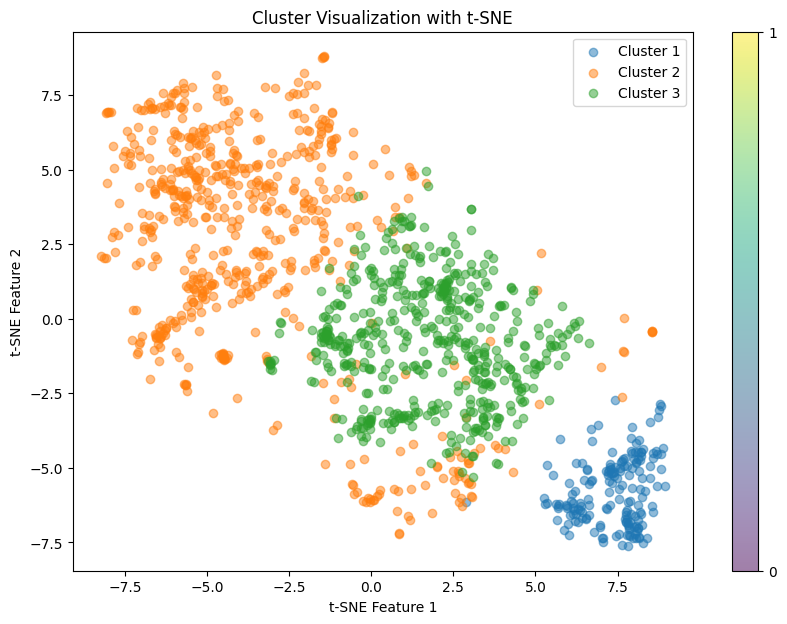

Cluster 1:
EUROSTAR fail! THEY WILL NEVER BE OUR FIRST CHOICE FOR TRAVEL - EUROSTAR fail! such a disappointment .. our train got cancelled, no customer service was provided at the time ABSOLUTE FAIL! ... we ended up driving last minute so we don’t loose out on our trip and activities and MIGHTY EUROSTAR is so poor they can’t even compensate the excess of less than £100 that we incurred above the cost of our ticket (not even mentioning stress incurred and travelling whole night for a weekend break booked in advance which was 2k... we chose alternative route because we didn’t want to miss out as no one would give us a refund and we didn’t have any other choice because no one from EUROSTAR bothered to show up or advice other than go in their website - which was crashing all the time - AS EXPECTED and tickets available for next day at reasonable time were all gone!) ... well done EUROSTAR! ... i would think twice before choosing your service again! www.eurostar.com
Terrible customer servic

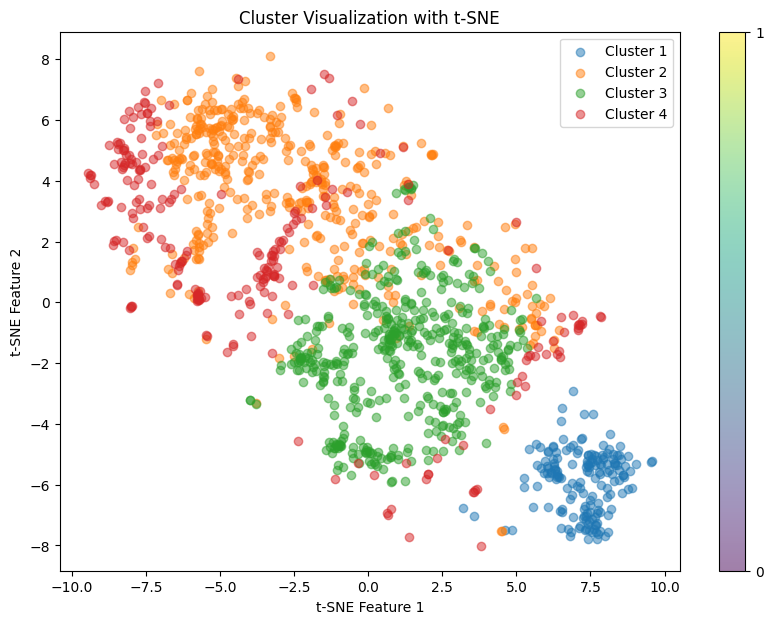

Cluster 1:
EUROSTAR fail! THEY WILL NEVER BE OUR FIRST CHOICE FOR TRAVEL - EUROSTAR fail! such a disappointment .. our train got cancelled, no customer service was provided at the time ABSOLUTE FAIL! ... we ended up driving last minute so we don’t loose out on our trip and activities and MIGHTY EUROSTAR is so poor they can’t even compensate the excess of less than £100 that we incurred above the cost of our ticket (not even mentioning stress incurred and travelling whole night for a weekend break booked in advance which was 2k... we chose alternative route because we didn’t want to miss out as no one would give us a refund and we didn’t have any other choice because no one from EUROSTAR bothered to show up or advice other than go in their website - which was crashing all the time - AS EXPECTED and tickets available for next day at reasonable time were all gone!) ... well done EUROSTAR! ... i would think twice before choosing your service again! www.eurostar.com
Terrible customer servic

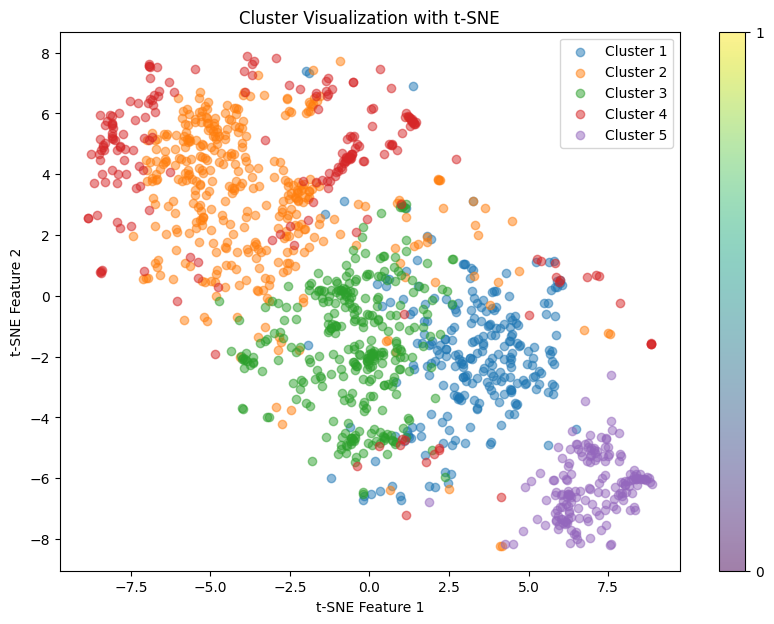

Cluster 1:
Still terrible - So bad customer service. The waiting time to get response is unbelievable .  I'm waiting about 8 months for refund my ticket .    Also I'm in train already which is 85 minute delay !!   The delay repay  scheme it is not fair ! www.virgintrains.co.uk
Do not use virgin trains! - I booked a virgin train ticket online but had to use the London Midland website because the virgin website kept crashing at the payment screen. When I got to Euston to collect my ticket from the machines there was a software problem so I could not retrieve my tickets so I showed a virgin customer service assistant my receipt and explained my circumstances but he refused to let me travel insisting I had to buy another ticket at a cost of £33. He was extremely rude and condescending and I had to go home and come back the next day and pay to travel again at gross inconvenience. I contacted virgin and they took a month to reply only to offer me a half price ticket for my next journey takin

In [22]:
for num_topics in [3,4,5]:
    cluster_labels, centroids = cluster_embeddings(embeddings, n_clusters=num_topics)
    visualize_clusters(embeddings, cluster_labels)
    print_most_relevant_docs_per_cluster(data, embeddings, cluster_labels, centroids, n_docs=3)

<a id='trains'></a>
## Clustering by train company

Sentence-BERT was a lot more insightful. We now know that users are mainly dissatisfied with the customer support, unexpected delays and cancellations, and high prices for poor quality service. Now we can explore what customers are saying about each of the companies independently. 

After analyzing the URLs from which the reviews have been taken, we have identified 5 subsets: Virgin Trains, Southern Railway, GWR, and Eurostar. The fifth subset contains reviews from the remaining train companies that have fewer than 100 reviews.

In [23]:
url_counts = Counter(review['url'] for review in data if 'url' in review)

# Sort the counts in descending order
sorted_url_counts = sorted(url_counts.items(), key=lambda x: x[1], reverse=True)

# Print the sorted counts
for url, count in sorted_url_counts:
    print(f"{url}: {count}")

www.virgintrains.co.uk: 410
www.southernrailway.com: 251
www.gwr.com: 173
www.eurostar.com: 172
www.virgintrainseastcoast.com: 108
www.nationalrail.co.uk: 60
www.buytickets.crosscountrytrains.co.uk: 20
www.eastmidlandstrains.co.uk: 19
www.tpexpress.co.uk: 18
www.southeasternrailway.co.uk: 18
www.arrivatrainswales.co.uk: 17
www.grandcentralrail.com: 17
www.southwesternrailway.com: 13
chilternrailways.co.uk: 8
www.londonnorthwesternrailway.co.uk: 8
sleeper.scot: 5
www.hulltrains.co.uk: 1


In [24]:
def split_data_by_url(data: List[Dict]) -> Dict[str, List[Dict]]:
    """Split data into subsets based on the URL."""
    subsets = {
        '1': [],
        '2': [],
        '3': [],
        '4': [],
        '5': []
    }
    
    for entry in data:
        url = entry['url']
        if url in ['www.virgintrains.co.uk', 'www.virgintrainseastcoast.com']:
            subsets['1'].append(entry)
        elif url in ['www.southernrailway.com', 'www.southeasternrailway.co.uk', 'www.southwesternrailway.com']:
            subsets['2'].append(entry)
        elif url == 'www.gwr.com':
            subsets['3'].append(entry)
        elif url == 'www.eurostar.com':
            subsets['4'].append(entry)
        else:
            subsets['5'].append(entry)
    return subsets

In [25]:
data = load_data(DATA_PATH)
subsets = split_data_by_url(data)

Removed 703 duplicates, 1318 reviews remain.


In [26]:
for idx, subset in subsets.items():
    with open(f'../data/subsets/subset{idx}.json', 'w') as fp:
        json.dump(subset, fp)

In [27]:
for idx, subset in subsets.items():
    print(subset[100]['url'])
    print(len(subset))

www.virgintrains.co.uk
518
www.southernrailway.com
282
www.gwr.com
173
www.eurostar.com
172
www.arrivatrainswales.co.uk
173


Subset: 1


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

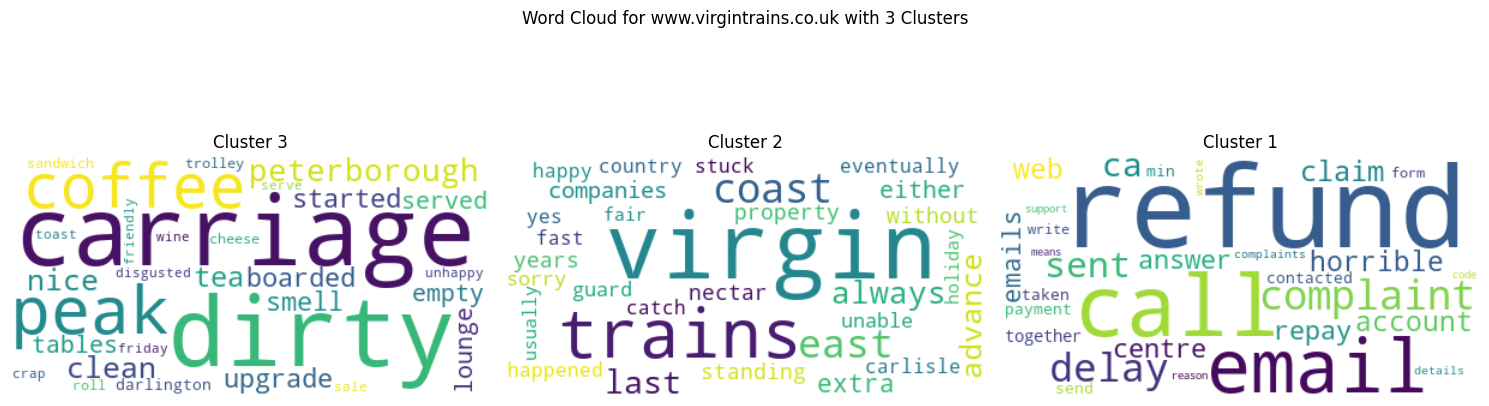

Subset: 2


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

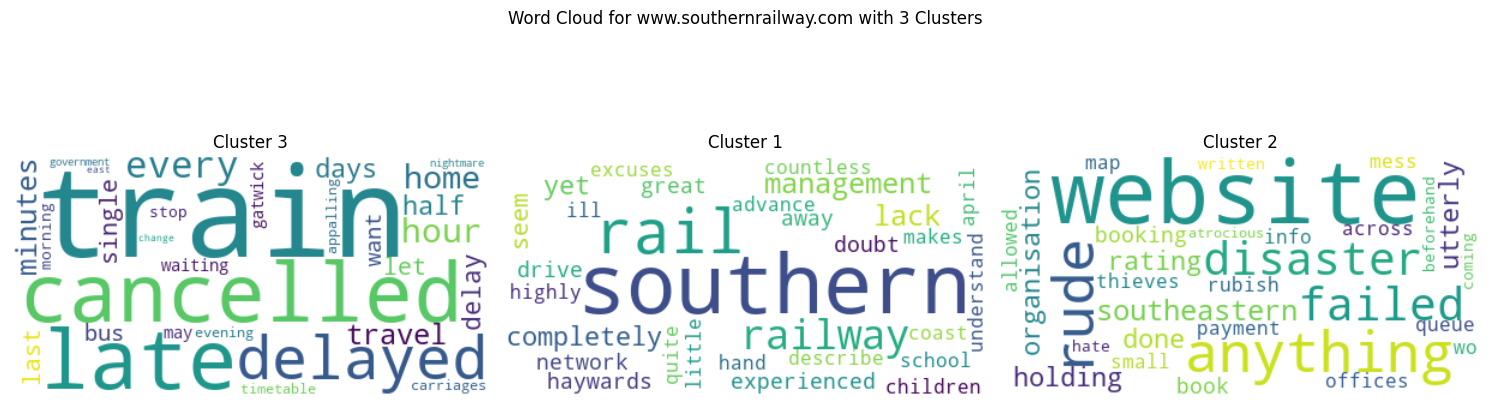

Subset: 3


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

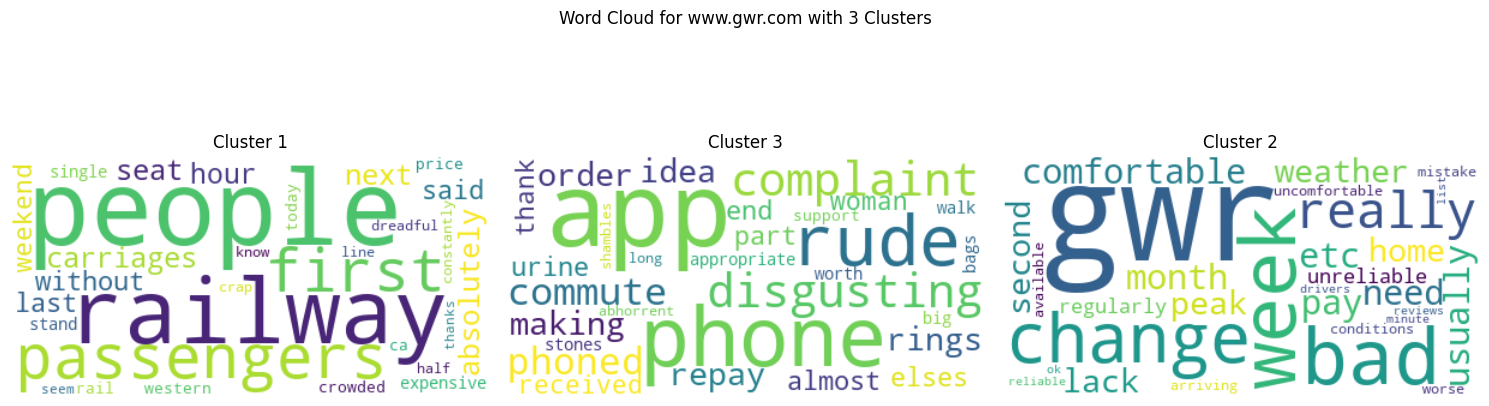

Subset: 4


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

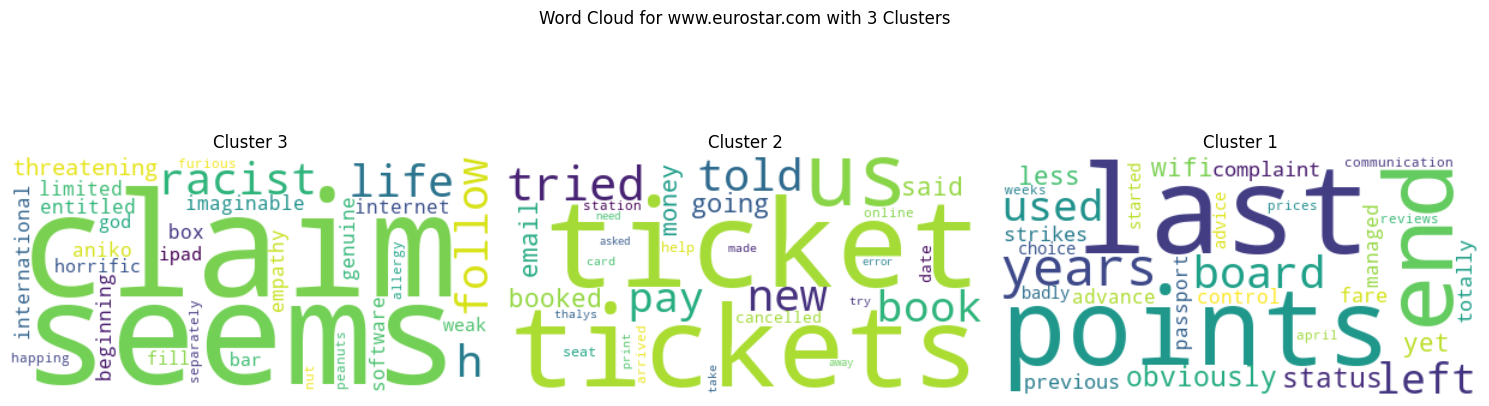

Subset: 5


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

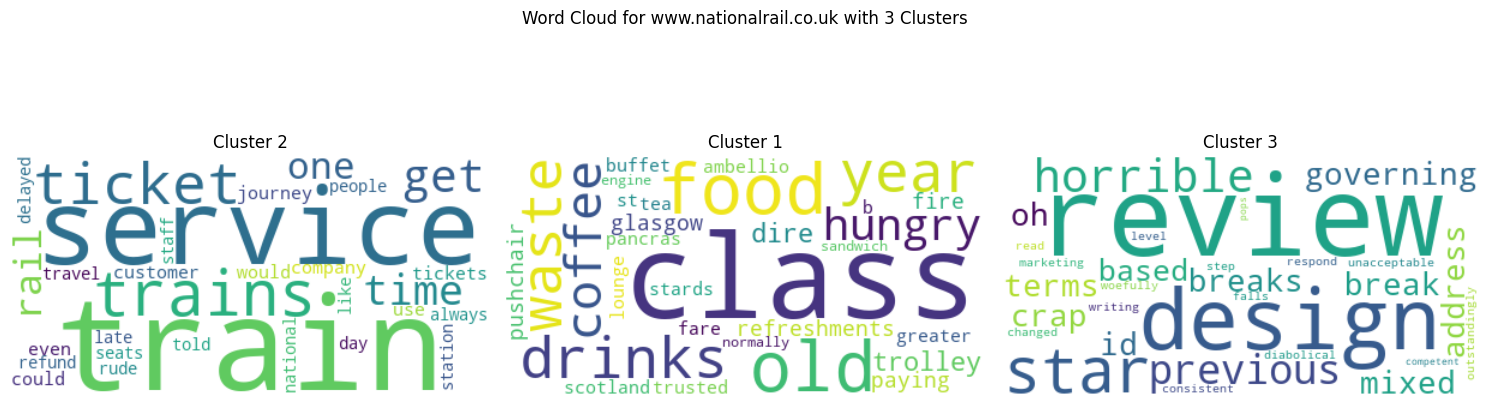

In [30]:
for idx, subset in subsets.items():
    print(f"Subset: {idx}")
    if subset:  # Check if the subset is not empty
        reviews = [preprocess_text_sbert(review['title'] + " " + review['text']) for review in subset]
        embeddings = generate_embeddings(reviews)
        cluster_labels, centroids = cluster_embeddings(embeddings, n_clusters=3)  # Assuming num_topics is set to 3

        title = f"Word Cloud for {subset[0]['url']} with 3 Clusters"
        generate_word_clouds(subset, cluster_labels, title=title, num_words=30)
        # visualize_clusters(embeddings, cluster_labels)
        # print_most_relevant_docs_per_cluster(subset, embeddings, cluster_labels, centroids, n_docs=3)
    else:
        print(f"No reviews in Subset {idx}, skipping...")
        